# Imports

I have yet to find a way to get ipycanvas working on colab.

In [1]:
import numpy as np
from numba import jit,cuda
from numba.cuda.random import create_xoroshiro128p_states, xoroshiro128p_uniform_float32
from matplotlib import pyplot as plt
import math,time
import scipy.ndimage.filters
from threading import Thread,Lock
from ipywidgets import Image, HBox
import ipywidgets as widgets
from ipycanvas import Canvas
import io


# Thread Management

In [2]:
class Cleanup():
    """The purpose of this is to keep track of all the threads I run, and terminate
    them with reset or hard_reset."""
    def __init__(self):
        self.threads = []
    def add(self,*threads):
        """Keep a list of active threads"""
        for thread in threads:
            self.threads.append(thread)
    def reset(self):
        """Threads with a while loop terminate according to a variable called isalive.
        This will terminate all running threads, but raise an exception with threads 
        that have not started yet"""
        for t in self.threads:
            t.isalive=False
            t.join()
        self.threads=[]
    def hard_reset(self):
        """This makes sure all threads have been started then terminates them."""
        for a in self.threads:
            try:
                a.start()
            except:
                pass
        self.reset()
cleaner = Cleanup()

# Collision Step

In the collision step of the Lattice Boltzmann Method with D2Q9 cells each cell is moved towards an equilibrium based on the cell's velocity components. Note: I added a force term to make the liquid generally flow in a specified direction.

D2Q9 represents 2 dimensions and 9 vectors. In an array, each 2D cell will have 9 values each for the fluid density moving in one of the D2Q9 directions.

The fi represent fluid densities moving in the ei directions. For example f1 represents the density moving north, f3 represents the density moving south, and f0 represents the density of still fluid. Say f1 and f3 are very large, then in the equilibrium step f1 and f3 will be decreased and f0 will be increased (if there is a lot of fluid moving up and a lot moving down, then they will interact and produce still fluid).
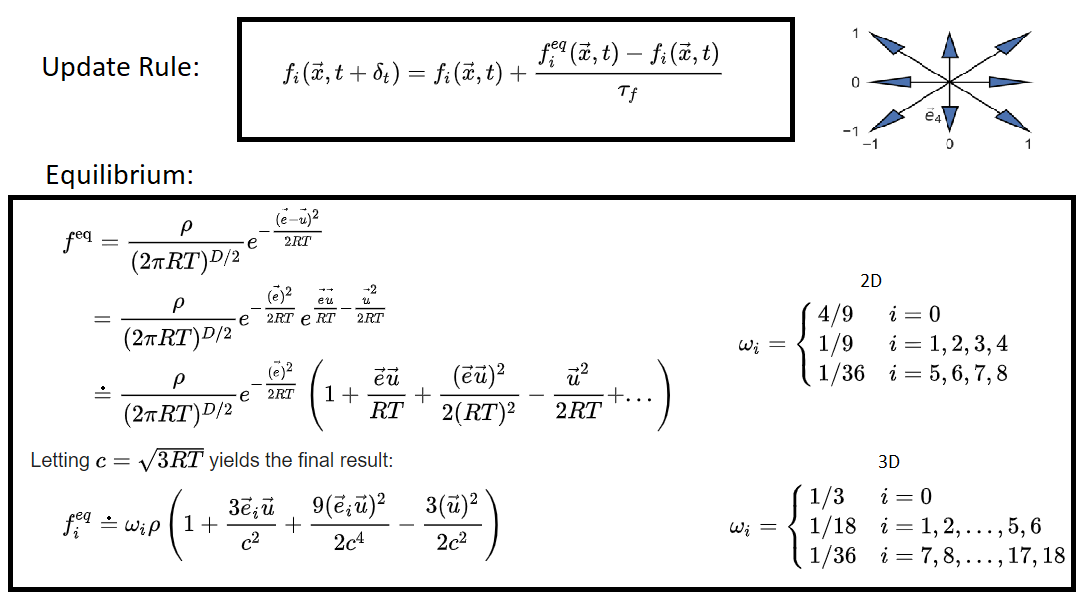

In [3]:
    
@cuda.jit(device=True)
def feq(x,y,ux,uy,w,p,c2):
    """Implementation of the equillibrium function shown above """
    #feq=wi*rho*(1+3ei.u/c^2+9(ei.u)^2/2c^4-3u^2/2c^2)
    dot=(x*ux+y*uy)*3/c2
    return w*p*(1+dot+dot**2/2-3*(ux*ux+uy*uy)/(2*c2))

@cuda.jit
def collision2DFlowSpeed(grid,viscosity,c,vx,vy,K):
    """Collision step in the D2Q9 LBM
    Params:
        grid:      (Input/Output) The D2Q9 array of fluid densities
        viscosity: (Input) The fluid viscosity
        c:         (Input) A temperature-like constant
        vx:        (Input) The target X velocity
        vy:        (Input) The target Y velocity
        K:         (Input) A multiplier for the force strength
        
    """
    i,j=cuda.grid(2)
    sx,sy,_=grid.shape
    if i>=sx or j>=sy:return
    #the grid represents our velocity density function
    cell=grid[i][j]
    itau = 1/(3*viscosity + 0.5)  #reciprocal of relaxation time
    c2=c**2
    #rho is the total density given by the sum of the velocity density function
    rho=(cell[0]+cell[1]+cell[2]+cell[3]+cell[4]+cell[5]+cell[6]+cell[7]+cell[8])
    if rho<=0:return
    #ordering is zero,n ,e ,s ,w ,ne,se,sw,nw
    #             0   1  2  3  4  5  6  7  8
    #velocity in x so east-west
    ux=(cell[2]-cell[4]+cell[5]+cell[6]-cell[7]-cell[8])/rho
    #velocity in y so north-south
    uy=(cell[1]-cell[3]+cell[5]+cell[8]-cell[6]-cell[7])/rho
    
    #wi= 4/9 for i=0, 1/9 for w in 1-4, 1/36 for i in 5-8
    
    
    #feq=wi*rho*(1+3ei.u/c^2+9(ei.u)^2/2c^4-3u^2/2c^2)
    #fi=fi+(feq-fi)/tao
    fy=(vy-uy)*rho/c2*K
    fx=(vx-ux)*rho/c2*K
    #Update move each velocity-density towards equilibrium
    cell[0]+=(feq(0,0,ux,uy,4/9,rho,c2)-cell[0])*itau
    #north
    cell[1]+=(feq(0,1,ux,uy,1/9,rho,c2)-cell[1])*itau+fy/9
    #east
    cell[2]+=(feq(1,0,ux,uy,1/9,rho,c2)-cell[2])*itau+fx/9
    #south
    cell[3]+=(feq(0,-1,ux,uy,1/9,rho,c2)-cell[3])*itau-fy/9
    #west
    cell[4]+=(feq(-1,0,ux,uy,1/9,rho,c2)-cell[4])*itau-fx/9
    #northeast
    cell[5]+=(feq(1,1,ux,uy,1/36,rho,c2)-cell[5])*itau+(fx+fy)/36
    #southeast
    cell[6]+=(feq(1,-1,ux,uy,1/36,rho,c2)-cell[6])*itau+(fx-fy)/36
    #southwest
    cell[7]+=(feq(-1,-1,ux,uy,1/36,rho,c2)-cell[7])*itau-(fx+fy)/36
    #northwest
    cell[8]+=(feq(-1,1,ux,uy,1/36,rho,c2)-cell[8])*itau+(-fx+fy)/36

# Streaming Step

The streaming step represents the movement of particles.
For example the value of f1 (northward fluid) in a cell will be transferred to the cell directly north of this, unless there is a boundary above, then it will be 'bounced back' and instead transfer the value to f3 (south) of the original cell
It adheres to the following updates:

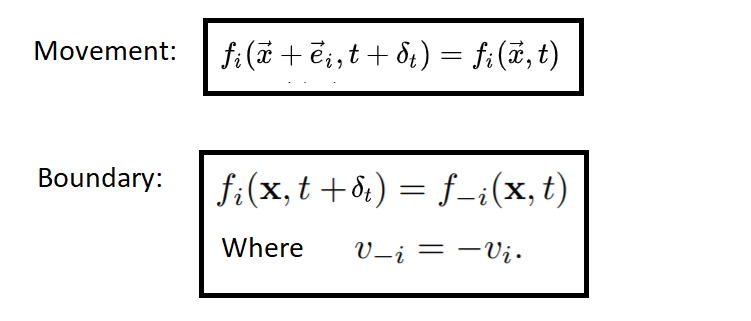

In [4]:
@cuda.jit
def streamGPU(grid,nextgrid,boundaries):
    """
      Params:
        grid:      (Input) The current D2Q9 array of fluid densities
        nextgrid:  (Output) The D2Q9 array of fluid densities after streaming is applied
        boundaries:(Input) Array where 0 or below represents free space and 1 or above represents a boundary
    """
    
    #ordering is zero,n ,e ,s ,w ,ne,se,sw,nw
    #             0   1  2  3  4  5  6  7  8
    sx,sy,_=grid.shape
    i,j=cuda.grid(2)
    if i>=sx or j>=sy:return
    if boundaries[i][j]>=0:return
    
    #no direction
    nextgrid[i][j][0]=grid[i][j][0]
    
    #north
    #if you do not encounter a boundary
    if boundaries[i+1-sx][j]<0:
        #move density to next cell
        nextgrid[i+1-sx][j][1]=grid[i][j][1]
    else:
        #bounce density off of boundary
        nextgrid[i][j][3]=grid[i][j][1]
    #south
    if boundaries[i-1][j]<0:
        #move density to next cell
        nextgrid[i-1][j][3]=grid[i][j][3]
    else:
        #bounce density off of boundary
        nextgrid[i][j][1]=grid[i][j][3]
    #east
    if boundaries[i][j+1-sy]<0:
        #move density to next cell
        nextgrid[i][j+1-sy][2]=grid[i][j][2]
    else:
        #bounce density off of boundary
        nextgrid[i][j][4]=grid[i][j][2]
    #west
    if boundaries[i][j-1]<0:
        #move density to next cell
        nextgrid[i][j-1][4]=grid[i][j][4]
    else:
        #bounce density off of boundary
        nextgrid[i][j][2]=grid[i][j][4]

    #northeast
    if boundaries[i+1-sx][j+1-sy]<0:
        #move density to next cell
        nextgrid[i+1-sx][j+1-sy][5]=grid[i][j][5]
    else:
        #bounce density off of boundary
        nextgrid[i][j][7]=grid[i][j][5]
    #southwest
    if boundaries[i-1][j-1]<0:
        #move density to next cell
        nextgrid[i-1][j-1][7]=grid[i][j][7]
    else:
        #bounce density off of boundary
        nextgrid[i][j][5]=grid[i][j][7]
    #northwest
    if boundaries[i+1-sx][j-1]<0:
        #move density to next cell
        nextgrid[i+1-sx][j-1][8]=grid[i][j][8]
    else:
        #bounce density off of boundary
        nextgrid[i][j][6]=grid[i][j][8]
    #southeast
    if boundaries[i-1][j+1-sy]<0:
        #move density to next cell
        nextgrid[i-1][j+1-sy][6]=grid[i][j][6]
    else:
        #bounce density off of boundary
        nextgrid[i][j][8]=grid[i][j][6]

# Island Generation code without any of the Gym stuff
Chris wrote this island generation (I did add a couple of lines). It can be found here:
https://github.com/CLEANit/SUBworld/tree/master/sub_algorithms/islands

In [5]:


min_height = 0.0 # Minimum height of an individual island (0 = No island, 1 = Ocean level)
max_height = 2.0 # Maximum height of an individual island (0 = No island, 1 = Ocean level)
x_decay_min = 1.5 # Minimum value to determine the decay rate in the x direction (0 = No decay, inf = Immediate decay)
x_decay_max = 3.0 # Maximum value to determine the decay rate in the x direction (0 = No decay, inf = Immediate decay)
y_decay_min = 1.5 # Minimum value to determine the decay rate in the y direction (0 = No decay, inf = Immediate decay)
y_decay_max = 3.0 # Maximum value to determine the decay rate in the y direction (0 = No decay, inf = Immediate decay)
crash_threshold = -0.1 # threshold of height for judging if submarine crash

class islandParameter(object):
    def __init__(self, x_size, y_size, max_h):
        self.height = np.random.uniform(low=min_height, high=max_h) # Height parameter
        self.x0 = np.random.uniform(low=0.0, high=x_size) # x position parameter
        self.y0 = np.random.uniform(low=0.0, high=y_size) # y position parameter
        self.a = np.random.uniform(low=x_decay_min, high=x_decay_max) # x variance parameter
        self.c = np.random.uniform(low=y_decay_min, high=y_decay_max) # y variance parameter
        b_lim = np.sqrt(self.a*self.c) # Maximum absolute value for co-variance parameter
        self.b = np.random.uniform(low=-1.0*b_lim, high=1.0*b_lim) # Co-variance parameter


class IslandMap_v1(object):
    def __init__(
        self,
        x_size = 5.0,
        y_size = 5.0,
        grid_size_x = 10,
        grid_size_y = 10,
        pixel_x = 100,
        pixel_y = 100,
        n_islands = 3,
        sub_size=0.05,
        port_size=0.10,
        island_size=1.0,
        max_vx = 0.5,
        max_vy = 0.5,
        buffer_size=0.1,
        level = 0,
        sub_level = 0.0,
        ):
        self.x_size = x_size # Size of map in x-direction
        self.y_size = y_size # Size of map in y-direction
        self.grid_size_x = grid_size_x # separate the map into X * Y grid, each grid has
        self.grid_size_y = grid_size_y # a water current velocity. these two var are the grid size
        self.pixel_x = pixel_x # Number of pixels in the x-direction of state
        self.pixel_y = pixel_y # Number of pixels in the y-direction of state
        self.n_islands = n_islands # Number of islands to generate
        self.max_vx = max_vx
        self.max_vy = max_vy
        self.sub_size = sub_size # Radius of submarine
        self.port_size = port_size # Radius of port
        self.buffer_size = buffer_size # Buffer region around the map for placing objects (0=objects can be placed against the outer walls)
        self.level = level # Difficulty used for curriculum learning (0 = Manual inputs used, 1 <= increasing difficulty)
        self.sub_level = sub_level # Parameter used to smoothly transition between levels

        # Define placement radius for Level 1
        if self.level == 1:
            self.place_range_sub_x = self.sub_level * ((self.x_size / 2) - (self.buffer_size+self.sub_size))
            self.place_range_sub_y = self.sub_level * ((self.y_size / 2) - (self.buffer_size+self.sub_size))
            self.place_range_port_x = self.sub_level * ((self.x_size / 2) - (self.buffer_size+self.port_size))
            self.place_range_port_y = self.sub_level * ((self.y_size / 2) - (self.buffer_size+self.port_size))
        else:
            self.place_range_sub_x = ((self.x_size / 2) - (self.buffer_size+self.sub_size))
            self.place_range_sub_y = ((self.y_size / 2) - (self.buffer_size+self.sub_size))
            self.place_range_port_x = ((self.x_size / 2) - (self.buffer_size+self.port_size))
            self.place_range_port_y = ((self.y_size / 2) - (self.buffer_size+self.port_size))

        # Define number of islands and their maximum heights for all Levels
        if self.level == 1:
            self.n_islands = 0
            self.max_heights = np.array([])
        elif self.level == 2:
            self.n_islands = 0
            self.max_heights = np.array([])
        elif self.level == 3:
            self.n_islands = 1
            self.max_heights = np.array([self.sub_level * (1.0 + crash_threshold)])
        elif self.level == 4:
            self.n_islands = 5
            self.max_heights = np.array([self.sub_level * (max_height - (1.0 + crash_threshold)) + (1.0 + crash_threshold), self.sub_level * (1.0 + crash_threshold), self.sub_level * (1.0 + crash_threshold), self.sub_level * (1.0 + crash_threshold), self.sub_level * (1.0 + crash_threshold)])
        elif self.level == 5:
            self.n_islands = 5
            self.max_heights = np.array([max_height, self.sub_level * (max_height - (1.0 + crash_threshold)) + (1.0 + crash_threshold), self.sub_level * (max_height - (1.0 + crash_threshold)) + (1.0 + crash_threshold), self.sub_level * (max_height - (1.0 + crash_threshold)) + (1.0 + crash_threshold), self.sub_level * (max_height - (1.0 + crash_threshold)) + (1.0 + crash_threshold)])
        elif self.level == 6:
            self.n_islands = 5
            self.max_heights = np.array([max_height, max_height, max_height, max_height, max_height])
        else:
            self.max_heights = np.zeros(self.n_islands, dtype=np.float32) + max_height

        # Create an array for land at bottom of the ocean
        self.island_list  = []
        for i in range(self.n_islands):
            island = islandParameter(x_size = self.x_size, y_size = self.y_size, max_h = self.max_heights[i])
            self.island_list.append(island)
        # Defining unit circle at (0, 0) for plotting 
        theta = np.linspace(0, 2*np.pi, 51, endpoint=True)
        self.circle = np.zeros((theta.shape[0], 2), dtype=np.float32)
        for i in range(theta.shape[0]):
            self.circle[i, 0] = np.cos(theta[i])
            self.circle[i, 1] = np.sin(theta[i])
        self.set_map()

    def set_map(self):
        # Create an array for land at bottom of the ocean
        self.island_list  = []
        for i in range(self.n_islands):
            island = islandParameter(x_size = self.x_size, y_size = self.y_size, max_h = self.max_heights[i])
            self.island_list.append(island)
        #I added this line -kyle
        self.heightMap=np.zeros([self.pixel_x,self.pixel_y])

        for i in range(self.pixel_x):
            for j in range(self.pixel_y):
                x_pos = i / self.pixel_x * self.x_size
                y_pos = j / self.pixel_y * self.y_size
                # Creating a land with given get_height_fun within range 0 to 1
                height = self.get_height(x_pos, y_pos)
                #I added this line - kyle
                self.heightMap[i][j]=height

    def get_height(self, x_pos, y_pos):
        height = -1.0
        for i in range(self.n_islands):
            for j in range(3):
                for k in range(3):
                    A = self.island_list[i].height
                    x0 = self.island_list[i].x0
                    y0 = self.island_list[i].y0
                    a = self.island_list[i].a
                    b = self.island_list[i].b
                    c = self.island_list[i].c
                    height += A * np.exp(
                        -1.0 * (
                            a * ( (x_pos + self.x_size * (j-1)) - x0) ** 2.0
                            + 2.0 * b * ((x_pos + self.x_size * (j-1))  - x0) * ( (y_pos + self.y_size * (k-1)) - y0)
                            + c * ( (y_pos + self.y_size * (k-1)) - y0) ** 2
                        )
                    )
        return height




# This sets up and runs the Fluid sim

In [6]:
class IslandWater(Thread):
    def __init__(self, islands,maxsteps=1e6,viscosity=0.2):
        #setup the lattice and helper data structures
        @cuda.jit
        def velocity(grid,V):
            """Calculate velocity of the fluid at each cell.
            Params:
                grid: (Input) The D2Q9 density array of shape (sx,sy,9)
                V:    (Output) The array of shape (sx,sy,2) containing the fluid velocity at each cell
            """
            i,j=cuda.grid(2)
            sx,sy,_=grid.shape
            if i>=sx or j>=sy:return
            cell=grid[i][j]
            rho=(cell[0]+cell[1]+cell[2]+cell[3]+cell[4]+cell[5]+cell[6]+cell[7]+cell[8])
            if rho>0:
                ux=(cell[2]-cell[4]+cell[5]+cell[6]-cell[7]-cell[8])/rho
                #velocity in y so north-south
                uy=(cell[1]-cell[3]+cell[5]+cell[8]-cell[6]-cell[7])/rho
            else:
                ux=uy=0
            V[i][j][0]=ux
            V[i][j][1]=uy
        #save callable velocity gpu function as
        self.vfunc=velocity
        #array containing velocity in x and y
        self.V=cuda.to_device(np.zeros([islands.shape[0],islands.shape[1],2]))
        self.maxsteps=maxsteps

        # initial and flow speed
        u0 =self.u0 = 0.1                            

        # Dummy initial flow
        #density still water
        n0 = (np.ones(islands.shape) - 1.5*u0**2)*4.0/9.0
        #density northward water. . .
        nN = (np.ones(islands.shape) - 1.5*u0**2)/9.0
        nS = (np.ones(islands.shape) - 1.5*u0**2)/9.0
        nE = (np.ones(islands.shape) + 3*u0 + 4.5*u0**2 - 1.5*u0**2)/9.0
        nW = (np.ones(islands.shape) - 3*u0 + 4.5*u0**2 - 1.5*u0**2)/9.0
        nNE = (np.ones(islands.shape) + 3*u0 + 4.5*u0**2 - 1.5*u0**2)/36.0
        nSE = (np.ones(islands.shape) + 3*u0 + 4.5*u0**2 - 1.5*u0**2)/36.0
        nNW = (np.ones(islands.shape) - 3*u0 + 4.5*u0**2 - 1.5*u0**2)/36.0
        nSW = (np.ones(islands.shape) - 3*u0 + 4.5*u0**2 - 1.5*u0**2)/36.0
        #create the D2Q9 grid
        GRID=np.zeros([islands.shape[0],islands.shape[1],9])
        GRID[:]=np.stack([n0,nN,nE,nS,nW,nNE,nSE,nSW,nNW]).transpose([1,2,0])
        print(GRID.shape)
        GRID[islands>=0]=0
        #set thread and block sizes for gpu execution
        self.threadsperblock = (16, 16)
        blockspergrid_x = int(np.ceil(GRID.shape[0] / self.threadsperblock[0]))
        blockspergrid_y = int(np.ceil(GRID.shape[1] / self.threadsperblock[1]))
        self.blockspergrid = (blockspergrid_x, blockspergrid_y)
        self.isalive=True
        #both grid1 and grid2 represent the D2Q9 density function
        self.grid1 = cuda.to_device(GRID)
        self.grid2=cuda.to_device(GRID.copy())
        self.c=1
        self.v=viscosity
        self.bounds=cuda.to_device(np.array(islands,dtype=np.float32))
        self.vx=self.vy=0
        super(IslandWater, self).__init__()
    def set_target_velocity(self,vx,vy):
        self.vx,self.vy=vx,vy
    def get_velocity(self):
        """This will return an array of shape (n,m,2) with vx and vy."""
        self.vfunc[self.blockspergrid, self.threadsperblock](self.grid1,self.V)
        return self.V.copy_to_host()
    def fps(self):
        """Gives the number of updates performed in one second"""
        iold = self.index
        time.sleep(1)
        return self.index-iold
    def run(self):
        """Run the fluid sim updates on a thread"""
        self.index=0
        while self.isalive and self.index<self.maxsteps:
            self.index+=1
            #perfroms streaming step. grid1 is unchanged grid2 contains the updated values
            #Recall these are cuda jitted so you need to index threads and blocks before giving params
            streamGPU[self.blockspergrid, self.threadsperblock](self.grid1,self.grid2,self.bounds)
            #perform equilibrium step on grid2
            collision2DFlowSpeed[self.blockspergrid, self.threadsperblock](self.grid2,self.v,self.c,self.vx,self.vy,5e-3)
            #perfroms streaming step. grid2 is unchanged grid1 contains the updated values
            streamGPU[self.blockspergrid, self.threadsperblock](self.grid2,self.grid1,self.bounds)
            #perform equilibrium step on grid1
            collision2DFlowSpeed[self.blockspergrid, self.threadsperblock](self.grid1,self.v,self.c,self.vx,self.vy,5e-3)


# I saved the delta cmap in a text file instead of installing Cmocean
maybe just use the terrain cmap instead

In [7]:
string="delta="
for line in open('delta.txt','r'):
    string+=line
exec(string)
import matplotlib
deltaCmap = matplotlib.colors.LinearSegmentedColormap('delta',delta)


# Nice Plot of the islands + water

(128, 128, 9)
0.09077339495388786


D:\Ananconda\envs\pytorch\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]


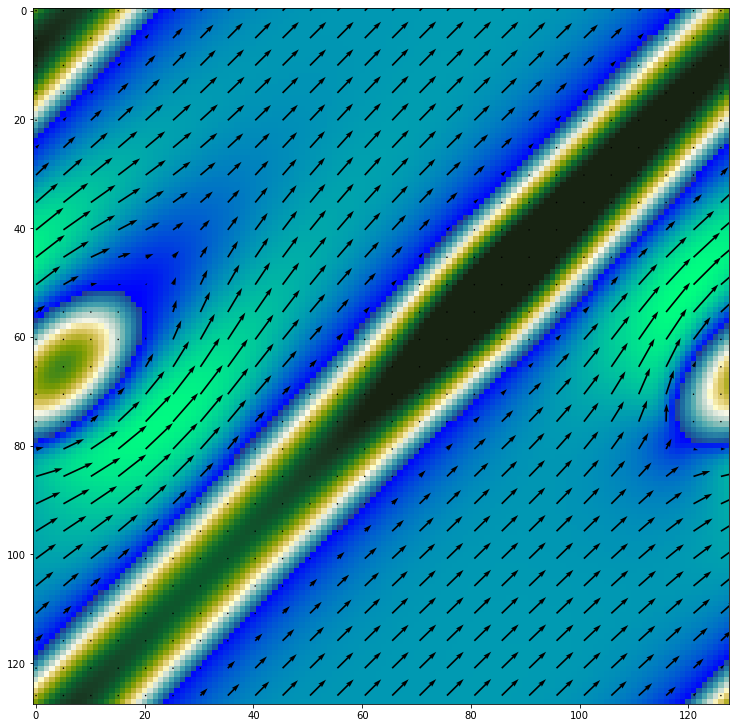

In [10]:
#Create the islands
islands=IslandMap_v1(pixel_x=128,pixel_y=128)
#Use the heightmap to initialize the fluid sim model
model = IslandWater(islands.heightMap,maxsteps=5e3,viscosity=0.05)
#set the target velocity (for the linear driving force)
model.set_target_velocity(0.1,0.0)
#run the model for 5e3 steps to reach equilibrium
model.run()
#set the plot size
plt.rcParams['figure.figsize'] = [12.8, 12.8]
#get the x and y fluid velocity from the model
vx,vy=model.get_velocity().transpose([2,0,1])
#meshgrid for specifying x and y coords in quiver
X,Y=np.meshgrid(*[np.linspace(0,128,128)]*2)
X=X[::5,::5]
Y=Y[::5,::5]
#imshow the magnitude of the velocity in shades of blue
plt.imshow((vx*vx+vy*vy)**0.5,cmap='winter')
print(np.max(vx*vx+vy*vy)**0.5)
#hacky way to overlay the islands
plt.imshow((islands.heightMap)*(1/(islands.heightMap>=0)),cmap=deltaCmap,vmin=-0.1,vmax=1)
#plot the vectors
plt.quiver(X,Y,vx[::5,::5],-vy[::5,::5])
plt.show()
plt.rcParams['figure.figsize'] = [6, 6]

# Rendering
The jetRGBArrow is custom quiver plot I wrote. It isn't essential to understand how it works, but I have a desmos
demo for the arrow rendering:
https://www.desmos.com/calculator/mpxaehsury

In [8]:
@cuda.jit
def jetRGBArrow(data,image,min_,max_,V):
    """Turns a [0,1] single channel image into an RGB one using the jet colormap, then
    plots vectors from a two channel image representing vector data
    Parameters:
        data:  (Input)  2D Array representing a single channel image
        image: (Output) 3D Array representing RGB values
        min_:  (Input)  Specifies the minimum value in data
        max_:  (Input)  Specifies the maximum value in data
        V:     (Input)  3D Array specifying Velocity in x-y
    """
    i,j=cuda.grid(2)

    #Recreating the jet colormap which specifies RGB values
    #for numbers in [0,1]
    gij = (data[i][j]-min_[0])/(max_[0]-min_[0])
    Red=((gij>0.35)&(gij<0.66))*(gij-0.35)/0.31
    Red+=(gij>0.66)&(gij<0.89)
    Red+=(gij>0.89)*(1-0.5*(gij-0.89)/0.11)
    #let R = gij<0.35?0:gij<0.66? (gij-0.35)/0.31:gij<0.89?1:1-0.5*(gij-0.89)/0.11
    Green=((gij>0.125)&(gij<0.375))*(gij-0.125)/0.25
    Green+=(gij>0.375)&(gij<0.64)
    Green+=((gij>0.64)&(gij<0.91))*(1-(gij-0.64)/0.27)
    #let G = gij<0.125?0:gij<0.375?(gij-0.125)/0.25:gij<0.64?1:gij<0.91?1-(gij-0.64)/0.27:0
    Blue=(gij<0.11)*(0.5+gij/0.22)
    Blue+=(gij>0.11)&(gij<0.34)
    Blue+=((gij>0.34)&(gij<0.65))*(1-(gij-0.34)/0.31)
    #let B = gij<0.11?0.5+gij/0.22:gij<0.34?1:gij<0.65?1-(gij-0.34)/0.31:0


    A=1.0;
    R=16
    ri=int(math.floor(i/R/2)*2*R+R)
    rj=int(math.floor(j/R/2)*2*R+R)
    #//coordintates of potential vector arrow this is part of
    
    #//for(let i1=0;i1<9;i1++){
    #//ri=(Math.floor(i/R/2+i1/3-1)*2*R+R)%512
    #//rj=(Math.floor(j/R/2+i1%3-1)*2*R+R)%512
        
    #//vector representing the field arrow
    dx=(R-7)*V[ri][rj][1]/max_[0]**0.5
    dy=(R-7)*V[ri][rj][0]/max_[0]**0.5
    m=(R-7)*((data[ri][rj])/max_[0])**0.5
    #dx=dy=m*0.707
    hs=min(m,3.5)
    #//now we check if our pixel is inside the arrow
    if (m>0):
        x = i-ri
        y=j-rj
        #//arrowhead can be done using inf and 1 norm in rotated coords
        X = dx*(dy-y)/m - dy*(dx-x)/m
        Y = dy*(dy-y)/m + dx*(dx-x)/m
        
        #// A<=0 if its in the arrowhead, 0<A<1 if its on the border A>1 if outside.
        A=min(A,max(-(hs-1.5*abs(X)-0.5*abs(Y)), -(hs-abs(Y+hs))));
        
        #//arrow body done by looking at length of orthogonal (to E field) part of pixel vector
        d=x*dx+y*dy
        X = x-d*dx/m/m
        Y = y-d*dy/m/m       
        if (d<m*m):
            #//Same assignment here but with the arrow body
            A=min(A,max(-3*d/hs,1-(hs/3.2-(X*X+Y*Y)**0.5)/0.4))
        #//clip A between 0 and 1
        A=max(A,0)
        
    image[i][j][0]=Red*255*A
    image[i][j][1]=Green*255*A
    image[i][j][2]=Blue*255*A

# Interactive Demo that can Generate Gifs

In [9]:
import glob
from PIL import Image as PImage

@cuda.jit
def upscale(inarr,outarr):
    """Simple upscaling function."""
    i,j=cuda.grid(2)
    iscale=outarr.shape[0]//inarr.shape[0]
    jscale=outarr.shape[1]//inarr.shape[1]
    outarr[i][j]=inarr[i//iscale][j//jscale][0]
@cuda.jit
def velocityinfo(inarr,outarr,min_,max_,V):
    """This sets the velocity components of V. and stores magnitudes in outarr
    Parameters:
        inarr:  (Input)  3D Array representing the D2Q9 lattice
        outarr: (Output) 2D Array representing speed
        min_:   (Output)  Specifies the minimum value in outarr
        max_:   (Output)  Specifies the maximum value in outarr
        V:      (Output)  3D Array specifying Velocity in x-y
    """
    i,j=cuda.grid(2)
    iscale=outarr.shape[0]//inarr.shape[0]
    jscale=outarr.shape[1]//inarr.shape[1]
    cell=inarr[i//iscale][j//jscale]
    rho=(cell[0]+cell[1]+cell[2]+cell[3]+cell[4]+cell[5]+cell[6]+cell[7]+cell[8])
    if rho>0:
        ux=(cell[2]-cell[4]+cell[5]+cell[6]-cell[7]-cell[8])/rho
        #velocity in y so north-south
        uy=(cell[1]-cell[3]+cell[5]+cell[8]-cell[6]-cell[7])/rho
    else:
        ux=uy=0
    outarr[i][j]=(ux*ux+uy*uy)
    V[i][j][0]=ux
    V[i][j][1]=uy
    cuda.atomic.max(max_,0,outarr[i][j])
    cuda.atomic.min(min_,0,outarr[i][j])

class Render(Thread):
    def __init__(self, globalmem, canvas,dim=[512,512],maxframes=0):
        self.maxframes=maxframes
        self.upscaled=cuda.to_device(np.zeros(dim))
        #cpu array with rgb values
        self.img=np.zeros(dim+[3])
        #gpu block and thread info
        self.threads=(16,16)
        self.blocks=(int(np.ceil(dim[0] / 16)),int(np.ceil(dim[1] / 16)))
        self.grid_global_mem = globalmem
        #gpu array to store x and y speeds
        self.V=cuda.to_device(np.zeros(dim+[2],dtype=np.float32))
        
        self.canvas = canvas
        self.isalive=True
        self.min=cuda.to_device(np.ones(1)*9999.9)
        self.max=cuda.to_device(np.ones(1)*-9999.9)
        super(Render, self).__init__()
    def run(self):
        allframes=[]
        while self.isalive:
            #get velocity and render it
            velocityinfo[self.blocks,self.threads](self.grid_global_mem,self.upscaled,self.min,self.max,self.V)
            jetRGBArrow[self.blocks,self.threads](self.upscaled,self.img,self.min,self.max,self.V)
            self.min,self.max=self.max,self.min
            image_data = self.img
            self.canvas.put_image_data(image_data, 0, 0)
            if len(allframes)<self.maxframes:
                allframes+=[PImage.fromarray(image_data.astype('uint8'))]
            time.sleep(0.01)
            
        if len(allframes)>0:
            fp_out = "Demo.gif"
            img, *imgs = allframes
            img.save(fp=fp_out, format='GIF', append_images=imgs,
                     save_all=True, duration=20, loop=0)
    def debug(self):
        velocityinfo[self.blocks,self.threads](self.grid_global_mem,self.upscaled,self.min,self.max,self.V)
        #jetRGB[self.blocks,self.threads](self.upscaled,self.img,self.min,self.max)
        time.sleep(0.01)
        print(self.max[0],self.min[0])
        self.min,self.max=self.max,self.min
            
            
            
            


In [10]:
islands=IslandMap_v1(pixel_x=128,pixel_y=128)
cleaner.hard_reset()    
model = IslandWater(islands.heightMap)
print(model.blockspergrid, model.threadsperblock)
canvas = Canvas(width=512,height=512)
rend = Render(model.grid1,canvas,dim=[512,512],maxframes=0)
#add threads to the cleaner so I can easily terminate
cleaner.add(model,rend)
model.start()
rend.start()

#this is just sliders and stuff for your interactive demo
def func(Temp,Viscosity,Row,Theta):
    model.c=Temp
    model.v=Viscosity
    model.vx=np.cos(Theta*2*np.pi)*Row
    model.vy=np.sin(Theta*2*np.pi)*Row
    
plswork = widgets.Layout(
    width='50%'
)
    
x = widgets.FloatSlider(min=1,max=2,value=1.0,step=0.001,layout=plswork)
x.style.handle_color = 'lightblue'
y = widgets.FloatSlider(min=0.005,value=0.2,max=0.5,step=0.0001,layout=plswork)
z = widgets.FloatSlider(min=0,value=0.0,max=1,step=0.0001,layout=plswork)
w = widgets.FloatSlider(min=0,value=0.1,max=0.1,step=0.0001,layout=plswork)
widgets.interact(func,Temp=x,Viscosity=y,Row=w,Theta=z)

canvas

(128, 128, 9)
(8, 8) (16, 16)


interactive(children=(FloatSlider(value=1.0, description='Temp', layout=Layout(width='50%'), max=2.0, min=1.0,…

Canvas(height=512, width=512)

In [18]:
rend.debug()

0.010000000000000004 0.0


In [11]:
cleaner.hard_reset() 

In [12]:
import matplotlib
matplotlib.cmaps.terrain

AttributeError: module 'matplotlib' has no attribute 'cmaps'